In [14]:
import argparse
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

from mlflux.predictor import FluxANNs
from mlflux.eval import open_case
from mlflux.gotm import read2010, Q, predict, gen_epsilon_flux, write_stoch_flux

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read inputs and predict fluxes (and generate noise)
A script for this is available in `script/gen_flux.py`

Demonstrate with 2015 series.

In [34]:
# REMEMBER TO CHANGE ACCORDINGLY
SHmodel_dir = '/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
LHmodel_dir = '/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
Mmodel_dir = '/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
rand = 4

# Path
input_folder = '/scratch/jw8736/mlflux/gotm/ows_papa/'
output_folder = '/scratch/jw8736/gotm/ensem/'

# Read and interpolate to hourly and then coarsen according to dt
df = read2010(input_folder, datetimeformat='%Y-%m-%d %H:%M:%S')    
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
ds_uniform = ds.resample(datetime='H').interpolate('linear') # Interpolation non-uniform to hourly
ds = ds_uniform.sel(datetime=slice('2015-01-01','2015-12-30')) 

dt_str = str(int(1)) + 'H' 
ds = ds.resample(datetime=dt_str).mean() 

# These are artificially assigned, for models that use these features
ds['zu'] = 10*ds['U']/ds['U']
ds['zt'] = 10*ds['U']/ds['U']
ds['zq'] = 10*ds['U']/ds['U']
ds = ds.rename({'t': 'tair', 'sst': 'tsea', 'q':'qair'})

# Predict by ANNs 
from mlflux.predictor import FluxANNs
ds = predict(ds, SHmodel_dir, LHmodel_dir, Mmodel_dir, rand)

ENSEM = 4
np.random.seed(0)
Q_eps_ensem = gen_epsilon_flux (ds, FLUX='heat', T=60, dt=1, ENSEM=ENSEM)
mean = (ds.qh_ann.values + ds.ql_ann.values + ds.lwr.values).reshape(-1, 1)

Predicting fluxes and stds based on ANNs in 
 SH directory /scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/
 LH directory /scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/
 M directory /scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/ ...
Finished!
Generating an ensemble of heat flux. Size=4.
Finished! eps_ensem array shape: (4, 8736)


Text(0, 0.5, '$Q_S+Q_L \\; (W/m^2)$')

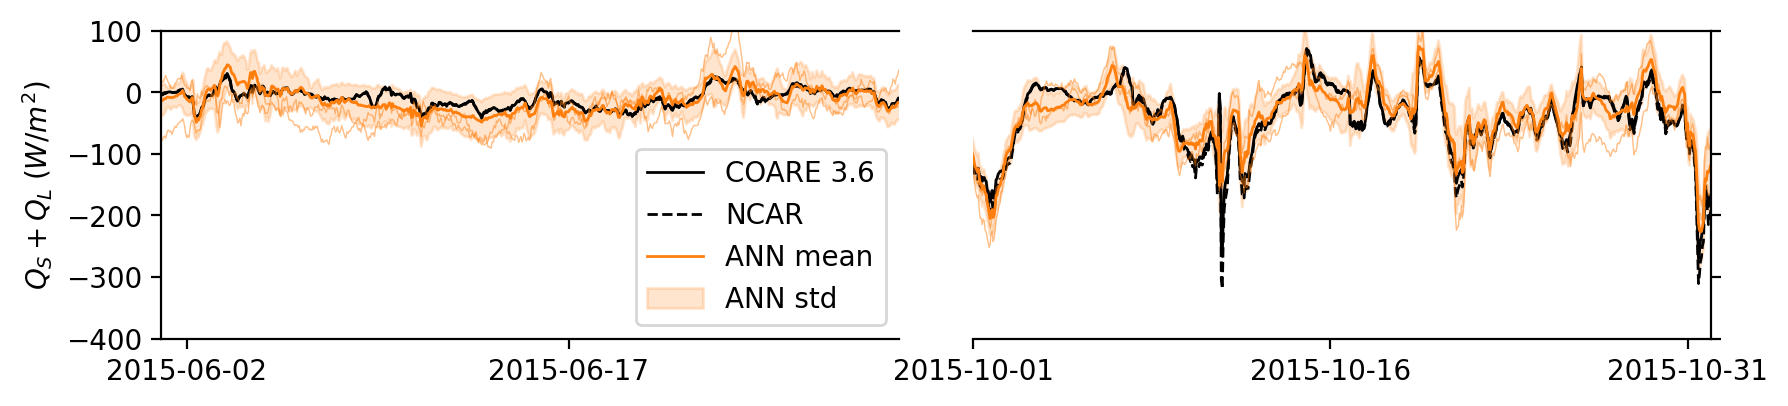

In [37]:
# computed from ANNs
from aerobulk.flux import noskin_np
fig, axes = plt.subplots(1, 2, figsize=[10,2], dpi=200, sharey=True)
plt.subplots_adjust(wspace=0.1)

###### Bulk (two methods)
ql, qh, taux, tauy, evap = noskin_np(sst=ds.tsea.to_numpy()+273.15, t_zt=ds.tair.to_numpy()+273.15, 
    hum_zt=ds.qair.to_numpy(), u_zu=ds.ux.to_numpy(), 
    v_zu=ds.uy.to_numpy(), slp=ds.p.to_numpy(), 
    algo='coare3p6', zt=18., zu=15., niter=6, input_range_check=True)
bulk1 = (ql + qh).reshape(-1,1)

ql, qh, taux, tauy, evap = noskin_np(sst=ds.tsea.to_numpy()+273.15, t_zt=ds.tair.to_numpy()+273.15, 
    hum_zt=ds.qair.to_numpy(), u_zu=ds.ux.to_numpy(), 
    v_zu=ds.uy.to_numpy(), slp=ds.p.to_numpy(), 
    algo='ncar', zt=18., zu=15., niter=6, input_range_check=True)
bulk2 = (ql + qh).reshape(-1,1)

axes[0].plot(ds.datetime, bulk1, '-', label='COARE 3.6', c='k', lw=1)
axes[0].plot(ds.datetime, bulk2, '--', label='NCAR', c='k', lw=1)
axes[1].plot(ds.datetime, bulk1, '-', label='COARE 3.6', c='k', lw=1)
axes[1].plot(ds.datetime, bulk2, '--', label='NCAR', c='k', lw=1)

ds['Qt_ann'] = ds['qh_ann'] + ds['ql_ann']
ds['Qt_std'] = (ds['qh_std']**2 + ds['ql_std']**2)**0.5

axes[0].plot(ds.datetime, ds['Qt_ann'], label='ANN mean', color='C1', lw=1)
axes[1].plot(ds.datetime, ds['Qt_ann'], color='C1', lw=1)

axes[0].fill_between(ds.datetime, ds['Qt_ann'] - ds['Qt_std'], ds['Qt_ann'] + ds['Qt_std'], 
                 color='C1', alpha=0.2, label='ANN std')
axes[1].fill_between(ds.datetime, ds['Qt_ann'] - ds['Qt_std'], ds['Qt_ann'] + ds['Qt_std'], 
                 color='C1', alpha=0.2)

for i in range(0, 2):
    axes[0].plot(ds.datetime, ds['Qt_ann'] + Q_eps_ensem[i], lw=0.5, alpha=0.5, c='C1')
    axes[1].plot(ds.datetime, ds['Qt_ann'] + Q_eps_ensem[i], lw=0.5, alpha=0.5, c='C1')

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
# plot the same data on both Axes
# zoom-in / limit the view to different portions of the data
# axes[0].set_xlim([pd.Timestamp('2012-07-01'), pd.Timestamp('2012-07-30')])
# axes[1].set_xlim([pd.Timestamp('2012-10-01'), pd.Timestamp('2012-11-01')])
axes[0].set_xlim([pd.Timestamp('2015-06-01'), pd.Timestamp('2015-06-30')])
axes[1].set_xlim([pd.Timestamp('2015-10-01'), pd.Timestamp('2015-11-01')])

# # hide the spines between ax and ax2
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].yaxis.tick_left()
# axes[0].tick_params(labelright='off')  # don't put tick labels at the top
# axes[1].tick_params(labelleft='off')  # don't put tick labels at the top
axes[1].yaxis.tick_right()

axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=15))
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=15))

axes[0].legend(loc='lower right')
axes[0].set_ylim([-400, 100]);
axes[0].set_ylabel(r'$Q_S+Q_L \; (W/m^2)$')
# fig.savefig(f'../plots/OWS_stochastic.png', bbox_inches='tight')

### Plot time series

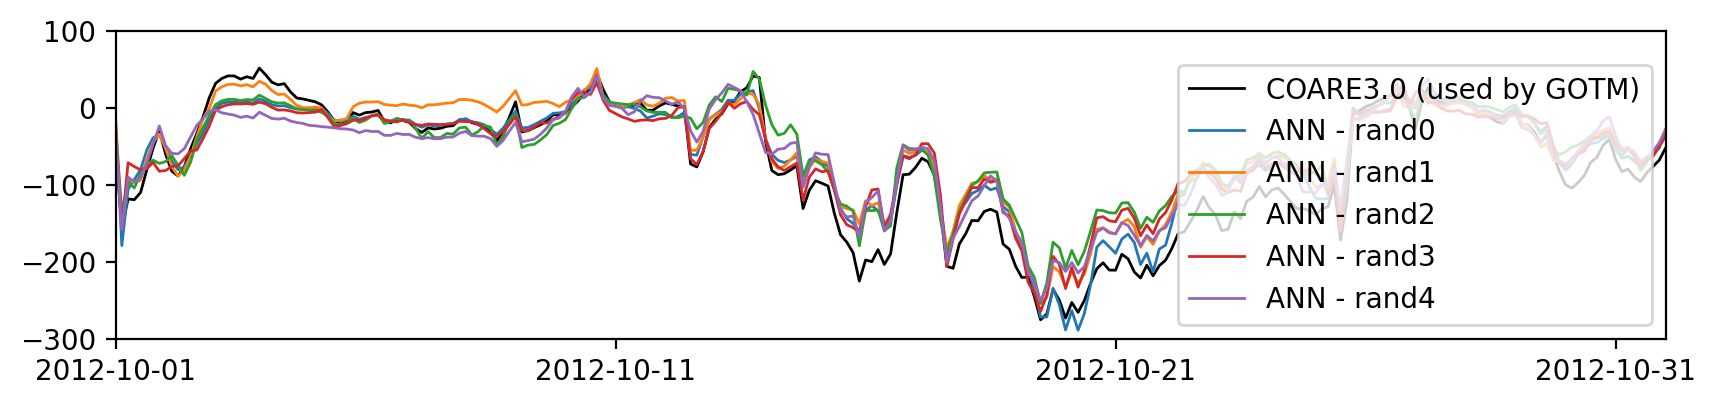

In [ ]:
###### Different random seeds in  
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

###### Bulk 
plt.plot(ds.datetime, ds.Q - ds.lwr, label='COARE3.0 (used by GOTM)', c='k', lw=1) 

###### ANNs
# SHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
# LHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
SHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
LHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
# SHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/SH4_1/tr2/'
# LHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/LH4_1/tr2/'

for rand in range(5):
    model_name = 'model_rand%g.p' %rand
    SHmodel = open_case (SHmodel_dir, model_name)  
    LHmodel = open_case (LHmodel_dir, model_name)
    ds = Q(ds, SHmodel, LHmodel)
    ds['Qt_ann'] = ds['qh_ann'] + ds['ql_ann']
    plt.plot(ds.datetime, ds.Qt_ann, label='ANN - rand%g' %rand,  lw=1) 

plt.xlim([pd.Timestamp('2012-10-01'),pd.Timestamp('2012-11-01')])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.legend(loc='lower right')
plt.ylim([-300, 100]);

### Attributing difference with Bulk

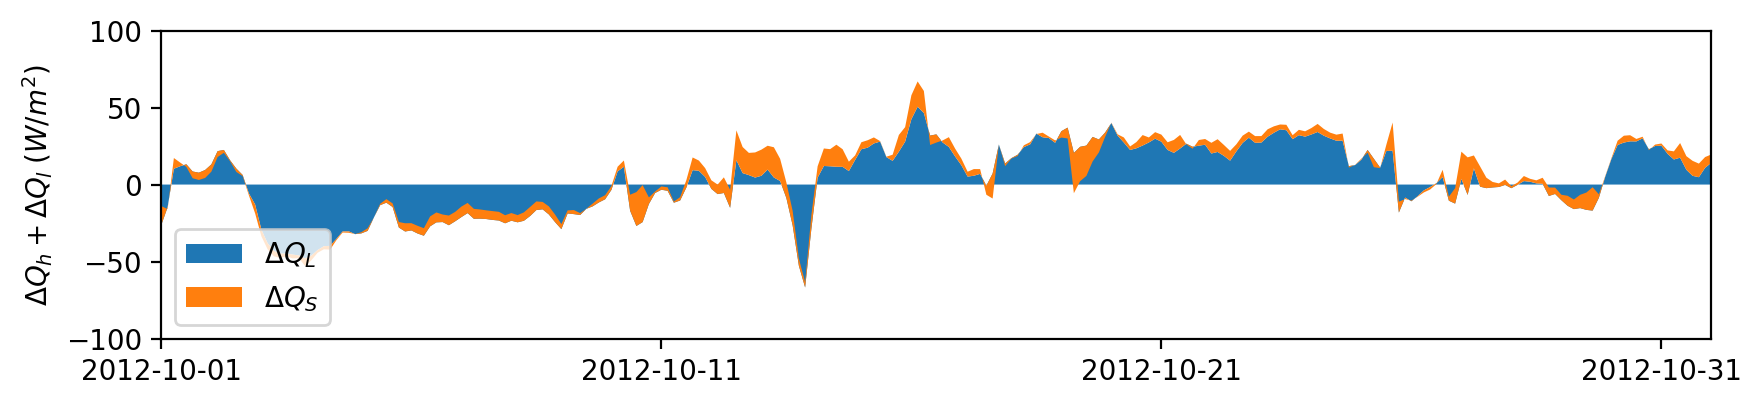

In [33]:
''' Heat flux difference decomposed '''

# computed bulk 
from aerobulk.flux import noskin_np
ql, qh, taux, tauy, evap = \
noskin_np(sst=ds.tsea.to_numpy()+273.15, t_zt=ds.tair.to_numpy()+273.15, 
       hum_zt=ds.qair.to_numpy(), u_zu=ds.ux.to_numpy(), 
       v_zu=ds.uy.to_numpy(), slp=ds.p.to_numpy(), 
       algo='coare3p0', zt=10., zu=10., niter=6, input_range_check=True)
# Sanity check that COARE3p0 is what GOTM uses
# plt.plot(ds.datetime, qh + ql, '--', label='COARE3p0', c='g', lw=1)
# plt.plot(ds.datetime, ds.Q - ds.lwr, '--', label='COARE3p0', c='g', lw=1)

fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()
y1 = ds.qh_ann - qh
y2 = ds.ql_ann - ql
plt.stackplot(ds.datetime, y2, y1, labels=['$\Delta Q_L$','$\Delta Q_S$'])
plt.legend(loc='lower left')
plt.ylabel('$\Delta Q_h + \Delta Q_l \; (W/m^2)$')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xlim([pd.Timestamp('2012-10-01'),pd.Timestamp('2012-11-01')])
plt.ylim([-100, 100]);

(15614.0, 15645.0)

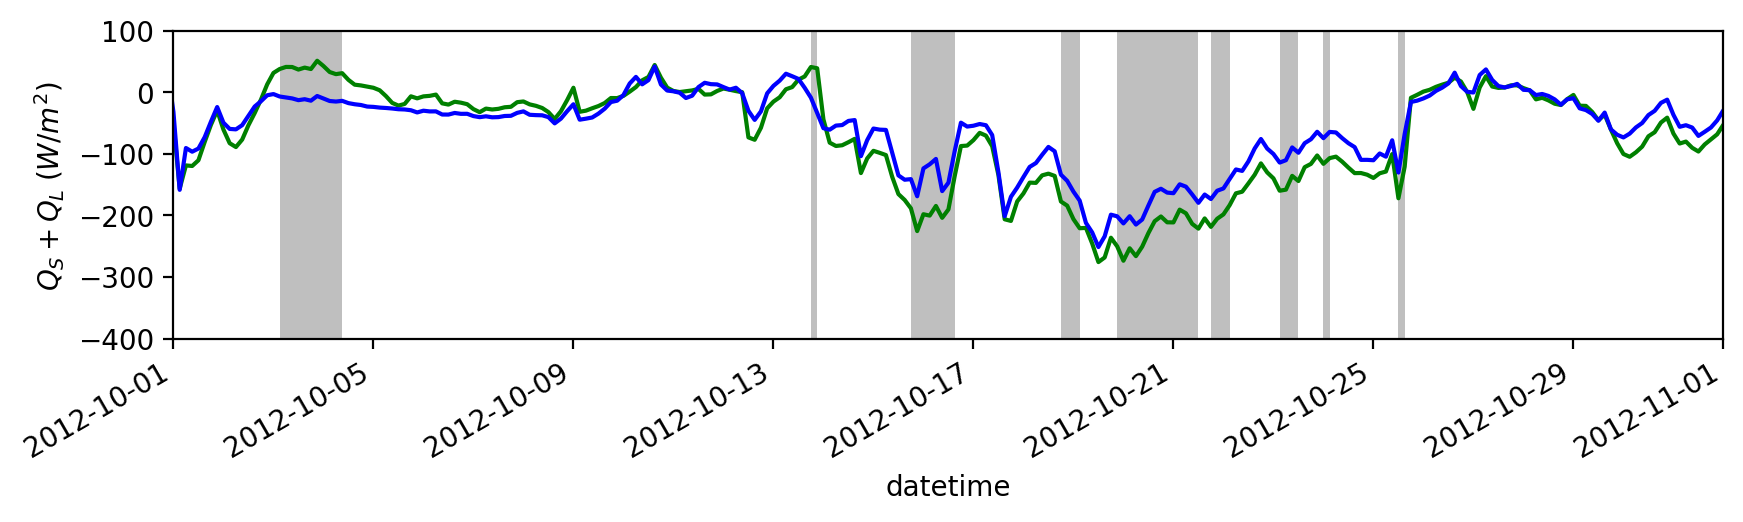

In [34]:
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

def plot_fill (ax, ds):
    # cond = abs(ds.Q - ds.lwr - ds.Qt_ann) / abs(ds.Q - ds.lwr + 0.0000001) > 1
    cond = abs(ds.Q - ds.lwr - ds.Qt_ann) > 40
    ds_far = ds.where(cond)
    (ds.Q-ds.lwr).plot(label='Bulk', c='g')
    ds.Qt_ann.plot(label='ANN', c='b')
    ax.set_ylim([-400,100]); ax.set_ylabel('$Q_S+Q_L\; (W/m^2)$ ')
    ax.fill_between(ds.datetime, -400, 100, where=cond, color='gray', alpha=0.5, edgecolor='None')

plot_fill (ax, ds)
plt.xlim([pd.Timestamp('2012-10-01'),pd.Timestamp('2012-11-01')])

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


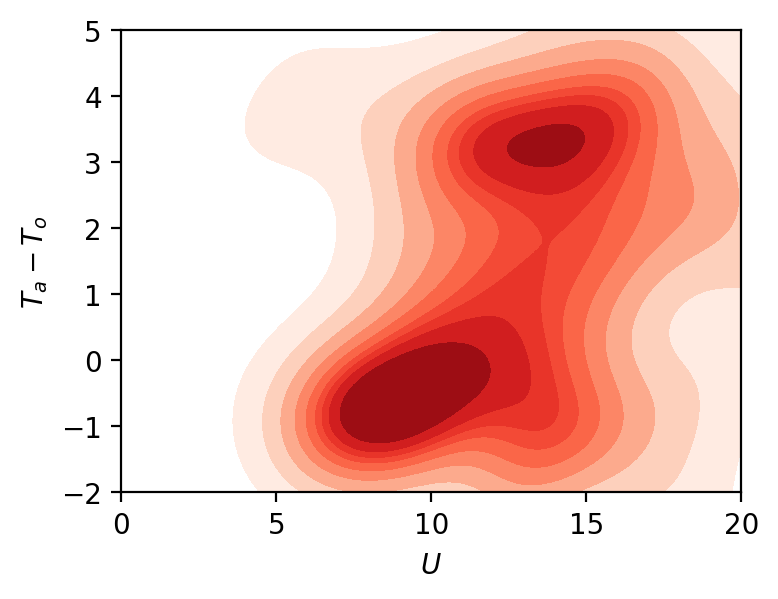

In [35]:
import seaborn as sns
fig = plt.figure(figsize=[4,3], dpi=200); ax = plt.gca()

cond = abs(ds.Q - ds.lwr - ds.Qt_ann) > 40
ds_far = ds.where(cond)

# sns.set_style("white")
sns.kdeplot(x=ds_far.U, y=ds_far.tsea-ds_far.tair, cmap="Reds", fill=True, ax=ax)
ax.set_xlabel('$U$'); ax.set_ylabel('$T_a-T_o$')
ax.set_xlim([0,20]); ax.set_ylim([-2,5]); plt.show()